In [ ]:
import tensorflow as tf

In [ ]:
# GPU Change
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Required Libraries

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
import os 
import pandas as pd
import numpy as np
import zipfile
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets,layers,models,Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D,AveragePooling2D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications
from tensorflow.keras.optimizers import RMSprop, Adam
# from keras.applications import MobileNetV2, VGG16
from keras.models import Model

Populating the interactive namespace from numpy and matplotlib


# Loading and Pre-processing the dataset

In [ ]:
# Spliting the Image data into Training and Testing 

from sklearn.model_selection import train_test_split as tts
WM_images=[x1 for x1 in os.listdir(r'/content/drive/MyDrive/Colab Notebooks/DLAssign3/dataset/with_mask') if x1[-3:]=='jpg']
WOM_images=[x2 for x2 in os.listdir(r'/content/drive/MyDrive/Colab Notebooks/DLAssign3/dataset/without_mask') if x2[-3:]=='jpg']

WM_train, WM_test = tts(WM_images, test_size = 0.3, random_state = 4)
WOM_train, WOM_test = tts(WOM_images, test_size = 0.3, random_state = 4)

In [ ]:
%cd /content
%pwd

/content


'/content'

In [ ]:
# Creating seperate directory for Train and Test data
!mkdir /content/Train
!mkdir /content/Train/with_mask
!mkdir /content/Train/without_mask
!mkdir /content/Test
!mkdir /content/Test/with_mask
!mkdir /content/Test/without_mask

In [ ]:
# Defining function for shifting image files from sources to the required destination
import shutil, os, glob
datapath = '/content/drive/MyDrive/Colab Notebooks/DLAssign3/dataset'
# os.chdir(os.path.join(datapath, 'with_mask' ))
def moveAllFilesinDir(srcDir, dstDir , flist):
# Check if both the are directories
  if os.path.isdir(srcDir) and os.path.isdir(dstDir):
    for filePath in flist:
        shutil.move(filePath, dstDir);
  else:
    print("srcDir & dstDir should be Directories")

In [ ]:
# Image Data transfering

tr_wm_img = []
for filename in WM_train:
  if filename.endswith(".jpg"):
    tr_wm_img.append("/content/drive/MyDrive/Colab Notebooks/DLAssign3/dataset/" +'with_mask'+'/' + filename)
    
sourceDir = '/content/drive/MyDrive/Colab Notebooks/DLAssign3/dataset/with_mask'
destDir =  '/content/Train/with_mask'
flist = WM_train
os.chdir(os.path.join(datapath, 'with_mask' ))
moveAllFilesinDir(sourceDir,destDir,flist)

tr_wom_img = []
for filename in WOM_train:
  if filename.endswith(".jpg"):
    tr_wom_img.append('/content/drive/MyDrive/Colab Notebooks/DLAssign3/dataset/without_mask'+'/' + filename)
    
sourceDir = '/content/drive/MyDrive/Colab Notebooks/DLAssign3/dataset/without_mask'
destDir =  '/content/Train/without_mask'
flist = WOM_train
os.chdir(os.path.join(datapath, 'without_mask' ))
moveAllFilesinDir(sourceDir,destDir,flist)

ts_wm_img = []
for filename in WM_test:
  if filename.endswith(".jpg"):
    ts_wm_img.append('/content/drive/MyDrive/Colab Notebooks/DLAssign3/dataset/with_mask'+'/' + filename)
    
sourceDir = '/content/drive/MyDrive/Colab Notebooks/DLAssign3/dataset/with_mask'
destDir =  '/content/Test/with_mask'
flist = WM_test
os.chdir(os.path.join(datapath, 'with_mask' ))
moveAllFilesinDir(sourceDir,destDir,flist)

ts_wom_img = []
for filename in WOM_test:
  if filename.endswith(".jpg"):
    ts_wom_img.append('/content/drive/MyDrive/Colab Notebooks/DLAssign3/dataset/without_mask'+'/' + filename)
    
sourceDir = '/content/drive/MyDrive/Colab Notebooks/DLAssign3/dataset/without_mask'
destDir =  '/content/Test/without_mask'
flist = WOM_test
os.chdir(os.path.join(datapath, 'without_mask' ))
moveAllFilesinDir(sourceDir,destDir,flist)

# Pre-processing the images present in the dataset using the TensorFlow preprocessing module 

In [ ]:
import tensorflow.keras.backend as k

img_width, img_height = 160,160  #width and height of the images
train_data_dir = r"/content/Train"
valid_data_dir= r"/content/Test"
batch_size= 20

if k.image_data_format()=='channels_first': 
    input_shape=(3, img_width, img_height)# fixing the input shape basis the input images. 
else:
    input_shape=(img_width,img_height,3)

train_datagen=ImageDataGenerator(rescale=1.0/255, shear_range =0.2, zoom_range=0.2, horizontal_flip =True)
test_datagen=ImageDataGenerator(rescale=1.0/255) # only scaling, no augmentation. 

train_generator =train_datagen.flow_from_directory(train_data_dir,
                                                    target_size =(img_width,img_height), 
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    classes=['with_mask','without_mask'] # taking names from the dir name
                                                    # With_Mask = 0, Without_Mask = 1 --> label identified by the network. 
                                                    )
valid_generator = test_datagen.flow_from_directory(valid_data_dir,
                                                    target_size =(img_width,img_height), 
                                                    batch_size=batch_size,
                                                    class_mode='binary'
                                                    )

Found 963 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


# Visualizing the images present in the dataset

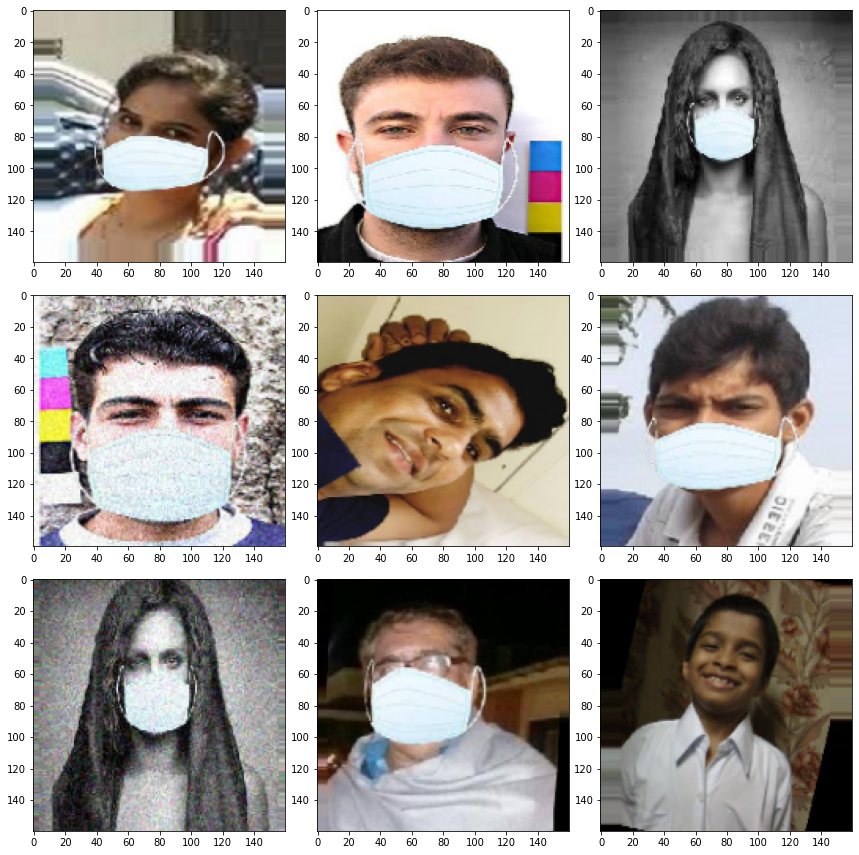

In [ ]:
# print some random images from the set of training and validation datasets. 
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Designing a CNN Model(M_np) using only Numpy Data(numerical values)

In [ ]:
from sklearn.model_selection import train_test_split as tts

data_np = np.load('/content/drive/MyDrive/Colab Notebooks/DLAssign3/Required Files/data.npy')
targ_np = np.load('/content/drive/MyDrive/Colab Notebooks/DLAssign3/Required Files/target.npy')

img_data=data_np.reshape(1376,10000)

df_img = pd.DataFrame(img_data)
df_cl = pd.DataFrame(targ_np, columns = ['C1','C2'])
df_all = pd.concat([df_img, df_cl], axis = 1)

x_train, x_test, y_train, y_test = tts(df_img,df_cl,test_size=0.4,random_state=8)

In [ ]:
y_tr = np.array(y_train)
y_ts = np.array(y_test)

Y_train = y_tr[:,0]
Y_test = y_ts[:,0]

X_tr = np.array(x_train).reshape(825,100,100)
X_ts = np.array(x_test).reshape(551,100,100)

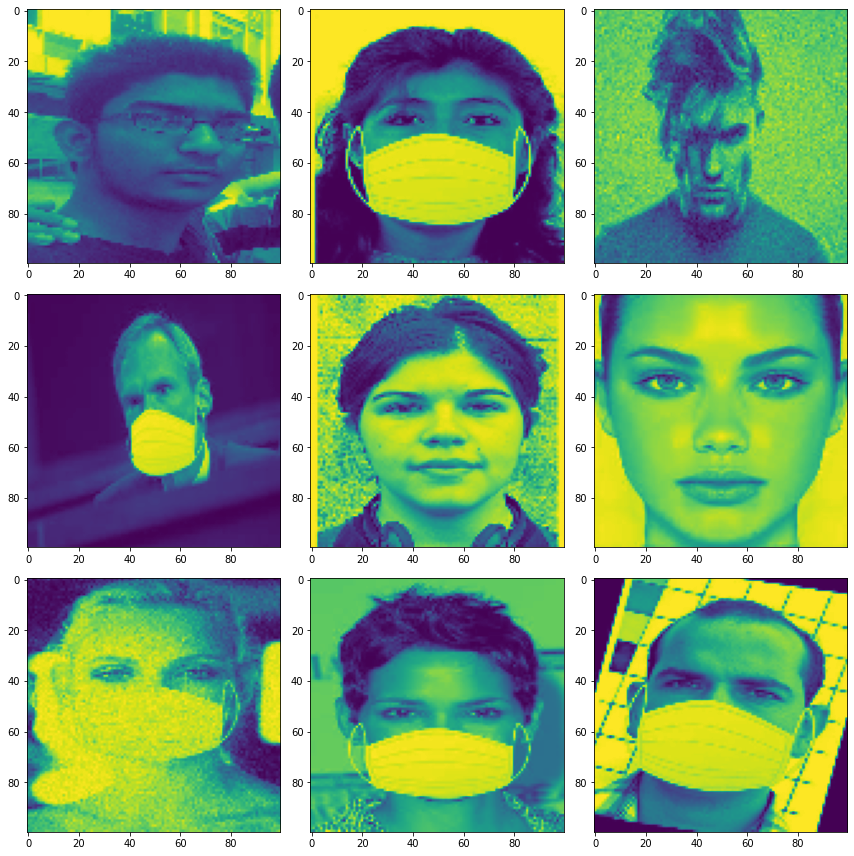

In [ ]:
plt.figure(figsize=(12, 12))
for idx,i in enumerate(list(range(10,19,1))):
  plt.subplot(3,3,idx+1)
  image = X_tr[i]
  plt.imshow(image)
plt.tight_layout()
plt.show()

In [ ]:
classes= ['With_Mask', 'Without_Mask']
def plot_sample(X, Y, index):
    plt.figure(figsize = (20,4))
    plt.imshow(X[index])
    plt.xlabel(classes[int(Y[index,0])])

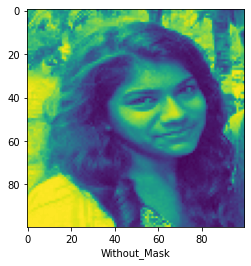

In [ ]:
plot_sample(X_tr, y_tr, 109)

In [ ]:
X_train = np.array(X_tr).reshape(825,100,100,1)
X_test = np.array(X_ts).reshape(551,100,100,1)

In [ ]:
M_np = models.Sequential([
        layers.Conv2D(filters=25,kernel_size=(3,3),activation='relu',input_shape=(100,100,1)),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(filters=50,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.5),
    
        layers.Conv2D(filters=100,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.5),
        
        layers.Flatten(),
        layers.Dense(150, activation='relu'),
        layers.Dense(1, activation='sigmoid')    
    ])
M_np.compile( loss = 'binary_crossentropy',
                    optimizer = Adam(),
                    metrics = ['accuracy'])
Trg_np=M_np.fit(X_train,Y_train, epochs=20, verbose=1)

Epoch 1/20
26/26 [==============================] - 31s 31ms/step - loss: 0.6865 - accuracy: 0.5358
Epoch 2/20
26/26 [==============================] - 1s 21ms/step - loss: 0.5279 - accuracy: 0.7564
Epoch 3/20
26/26 [==============================] - 1s 22ms/step - loss: 0.3528 - accuracy: 0.8424
Epoch 4/20
26/26 [==============================] - 1s 21ms/step - loss: 0.2166 - accuracy: 0.9224
Epoch 5/20
26/26 [==============================] - 1s 22ms/step - loss: 0.1551 - accuracy: 0.9455
Epoch 6/20
26/26 [==============================] - 1s 22ms/step - loss: 0.1517 - accuracy: 0.9370
Epoch 7/20
26/26 [==============================] - 1s 22ms/step - loss: 0.1203 - accuracy: 0.9564
Epoch 8/20
26/26 [==============================] - 1s 22ms/step - loss: 0.0917 - accuracy: 0.9697
Epoch 9/20
26/26 [==============================] - 1s 22ms/step - loss: 0.0765 - accuracy: 0.9721
Epoch 10/20
26/26 [==============================] - 1s 22ms/step - loss: 0.0650 - accuracy: 0.9782
Epoch 11

# Using Image Data & PREPARE THE DATA

In [ ]:
M_np.evaluate(X_test,Y_test)

18/18 [==============================] - 0s 11ms/step - loss: 0.0925 - accuracy: 0.9710


[0.09247292578220367, 0.97096186876297]

In [ ]:
y_pred = M_np.predict(X_test)

With Mask


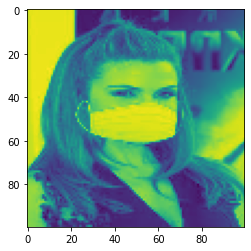

In [ ]:
idx = 119
if y_pred[idx] > 0.5:
  plt.imshow(X_ts[i])
  print('Without Mask')
else:
  plt.imshow(X_ts[i])
  print('With Mask')

In [ ]:
%cd /content

/content


# Designing a CNN Model(M2_mnV2) using MobileNetV2 Architecture & Image data files

In [ ]:
# MobileNetV2 Architecture 
earlystop = EarlyStopping(monitor='accuracy',  
                          patience = 2,
                          min_delta = 0.005, # 0.01
                          mode='max') # overall expectations --> accuracy of the model should be Max()

pt_model = keras.applications.MobileNetV2(input_shape=input_shape,
                                          include_top=False, 
                                          weights='imagenet')

for layer in pt_model.layers[:75]: 
    layer.trainable = False

for layer in pt_model.layers[75:]:
    layer.trainable = True
    
last_layer = pt_model.get_layer('block_16_expand')
last_output = last_layer.output
    
x = Dense(64, activation='relu')(last_output) # 64
x = AveragePooling2D(pool_size=(2,2))(x)
x = Flatten()(x)
x = layers.Dense(128, activation='relu')(x) # 128
# x = Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

M2_mnV2 = Model(pt_model.input, x)

M2_mnV2.compile(optimizer = 'adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# M2_mnV2.summary()

Trg2 = M2_mnV2.fit( train_generator,
                    steps_per_epoch=40,
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=20,
                    callbacks=[earlystop])

Epoch 1/30
40/40 [==============================] - 15s 278ms/step - loss: 0.1705 - accuracy: 0.9502 - val_loss: 0.0427 - val_accuracy: 0.9975
Epoch 2/30
40/40 [==============================] - 10s 248ms/step - loss: 0.0435 - accuracy: 0.9911 - val_loss: 8.9951e-06 - val_accuracy: 1.0000
Epoch 3/30
40/40 [==============================] - 10s 258ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0649 - val_accuracy: 0.9975


# Ploting the training history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


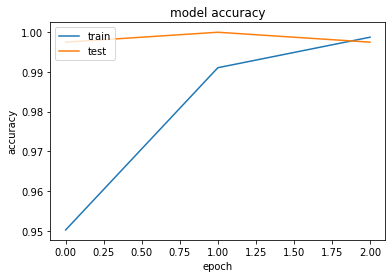

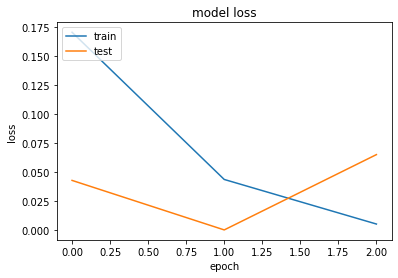

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in training
print(Trg2.history.keys())

# summarize training for accuracy
plt.plot(Trg2.history['accuracy'])
plt.plot(Trg2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize training for loss
plt.plot(Trg2.history['loss'])
plt.plot(Trg2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluating the Model

In [ ]:
M2_mnV2.evaluate_generator(valid_generator, steps=10, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.1298990100622177, 0.9950000047683716]

In [ ]:
from tensorflow.keras.preprocessing import image
wm = []
for i in WM_test:
  img='/content/Test/with_mask/' + i
  img_pred = image.load_img(img,target_size=(160,160))
  img_pred=image.img_to_array(img_pred)
  img_pred=np.expand_dims(img_pred, axis=0)
  result = M2_mnV2.predict(img_pred)
  wm.append(result[0][0])

wom = []
for i in WOM_test:
  img='/content/Test/without_mask/' + i
  img_pred = image.load_img(img,target_size=(160,160))
  img_pred=image.img_to_array(img_pred)
  img_pred=np.expand_dims(img_pred, axis=0)
  result = M2_mnV2.predict(img_pred)
  wom.append(result[0][0])

m2_wm = wm
m2_wom = wom
print(mean(m2_wm))
print(mean(m2_wom))

0.031007446
0.97551966


# To Check Error on Top 20% sorted data

In [ ]:
print('FALSE POSITIVE- IF values Greater Than 0.5')
m2_wm.sort()
m2_wm[-1:-11:-1]

FALSE POSITIVE- IF values Greater Than 0.5


[1.0,
 1.0,
 1.0,
 0.99990416,
 0.99867827,
 0.9984339,
 0.4206535,
 0.0007296949,
 0.00010766532,
 3.4492063e-05]

In [ ]:
print('FALSE NEGATIVE- IF values Lesser Than 0.5')
m2_wom.sort()
m2_wom[0:10]

FALSE NEGATIVE- IF values Lesser Than 0.5


[1.3692839e-10,
 3.1549092e-08,
 4.2095608e-06,
 5.4206625e-06,
 0.2550797,
 0.82913834,
 0.94327706,
 0.9591157,
 0.9733489,
 0.9978962]

# Saving the Entire Model and Weights

In [ ]:
import json
from keras.models import model_from_json
from keras.models import load_model
from keras.preprocessing import image

# export the model as JSON. 
model_json = M2_mnV2.to_json()
with open("M2.json", "w") as json_file:
    json_file.write(model_json)

M2_mnV2.save_weights('M2.h5')
M2_mnV2.save('M2_mnV2')
print("[INFO] Saved model to disk")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: M2_mnV2/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


[INFO] Saved model to disk


# Testing it using a webcam using OpenCV, and detect the Face Masks in real-time

In [ ]:
# Photo Capture for Real Time Test in Google Colab
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
%cd '/content'
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

img=mpimg.imread('/content/photo.jpg')
imgplot = plt.imshow(img)

IN CASE OF JUPYTER NOTEBOOK USE BELOW CODES

In [ ]:
# Photo Capture for Real Time Test in Jupyter NoteBook
# import cv2
# import numpy as np

# while True:
#     cap = cv2.VideoCapture(0)
#     cap.set(3,640)
#     cap.set(4,480)
#     cap.set(10, 80)
#     sucess, img = cap.read()
#     print(img.shape)
#     cv2.imshow('output',img)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# Use 'img' for Real Time Photos

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
img_pred = image.load_img('/content/photo.jpg',target_size=(160,160))
# img_pred = image.load_img('/content/Test/without_mask/130.jpg',target_size=(160,160))
# img_pred = image.load_img('/content/Test/with_mask/122-with-mask.jpg',target_size=(160,160))

img_pred=image.img_to_array(img_pred)
img_pred=np.expand_dims(img_pred, axis=0)

result = M2_mnV2.predict(img_pred)

print(result)
if result[0][0]>0.5:
    prediction ="Without_Mask"
else:
    prediction ="With_Mask"
print('Prediction: ',prediction)

img=mpimg.imread('/content/photo.jpg')
# img=mpimg.imread('/content/Test/without_mask/130.jpg')
# img=mpimg.imread('/content/Test/with_mask/122-with-mask.jpg')

imgplot = plt.imshow(img)
plt.show()

Custom Based CNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, AveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(monitor='accuracy', # accuracy is the parameter of interest. 
                          patience = 5, # how much time we will wait
                          min_delta = 0.005, # min change expected in the acc value. 
                          mode='max') # overall expectations --> accuracy of the model should be Max() 

M_cnn = Sequential()
M_cnn.add(Conv2D(64,(3,3),input_shape=input_shape)) # 32 neurons with 3*3 filter
M_cnn.add(Activation('relu'))
M_cnn.add(AveragePooling2D(pool_size=(2,2)))
M_cnn.add(Conv2D(64,(3,3),input_shape=input_shape)) # 64 neurons with 3*3 filter
M_cnn.add(Activation('relu'))
M_cnn.add(AveragePooling2D(pool_size=(2,2)))
M_cnn.add(Flatten()) ### THIS FLATTEN LAYER IS THE OUTPUT OF CNN GOING INTO ANN --> this is the connection between CNN & ANN. 
M_cnn.add(Dense(128)) # 64 neurons
M_cnn.add(Activation('relu'))
M_cnn.add(Dropout(0.5))# Prevents overfitting of the model and it has the effect of reducing the capacity or thinning the network during training 
M_cnn.add(Dense(1)) # output layer
M_cnn.add(Activation('sigmoid')) # sigmoid activation function

M_cnn.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# M_cnn.summary()

Trg_cnn = M_cnn.fit(train_generator,
                      steps_per_epoch=40,
                      epochs=40,
                      validation_data=valid_generator,
                      validation_steps=20,
                      callbacks=[earlystop])

Epoch 1/40
40/40 [==============================] - 11s 255ms/step - loss: 0.7552 - accuracy: 0.7356 - val_loss: 0.1984 - val_accuracy: 0.9325
Epoch 2/40
40/40 [==============================] - 10s 247ms/step - loss: 0.1854 - accuracy: 0.9413 - val_loss: 0.1189 - val_accuracy: 0.9450
Epoch 3/40
40/40 [==============================] - 9s 234ms/step - loss: 0.1379 - accuracy: 0.9604 - val_loss: 0.0941 - val_accuracy: 0.9700
Epoch 4/40
40/40 [==============================] - 10s 247ms/step - loss: 0.1069 - accuracy: 0.9700 - val_loss: 0.1169 - val_accuracy: 0.9575
Epoch 5/40
40/40 [==============================] - 10s 243ms/step - loss: 0.0674 - accuracy: 0.9796 - val_loss: 0.0662 - val_accuracy: 0.9775
Epoch 6/40
40/40 [==============================] - 10s 239ms/step - loss: 0.0877 - accuracy: 0.9668 - val_loss: 0.0730 - val_accuracy: 0.9675
Epoch 7/40
40/40 [==============================] - 10s 238ms/step - loss: 0.0632 - accuracy: 0.9770 - val_loss: 0.1488 - val_accuracy: 0.9425


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


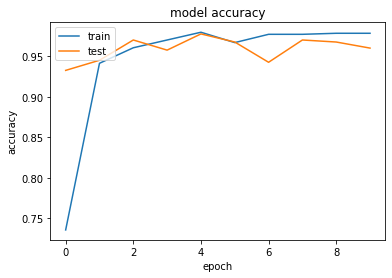

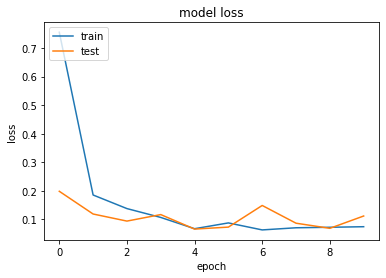

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in training
print(Trg_cnn.history.keys())

# summarize training for accuracy
plt.plot(Trg_cnn.history['accuracy'])
plt.plot(Trg_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize traning for loss
plt.plot(Trg_cnn.history['loss'])
plt.plot(Trg_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
M_cnn.evaluate_generator(valid_generator, steps=20, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.11161011457443237, 0.9599999785423279]

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
wm = []
for i in WM_test:
  img='/content/Test/with_mask/' + i
  # img=mpimg.imread(img)
  img_pred = image.load_img(img,target_size=(160,160))
  img_pred=image.img_to_array(img_pred)
  img_pred=np.expand_dims(img_pred, axis=0)
  result = M_cnn.predict(img_pred)
  wm.append(result[0][0])

wom = []
for i in WOM_test:
  img='/content/Test/without_mask/' + i
  # img=mpimg.imread(img)
  img_pred = image.load_img(img,target_size=(160,160))
  img_pred=image.img_to_array(img_pred)
  img_pred=np.expand_dims(img_pred, axis=0)
  result = M_cnn.predict(img_pred)
  wom.append(result[0][0])

mcnn_wm = wm
mcnn_wom = wom
print(mean(mcnn_wm))
print(mean(mcnn_wom))

0.009661827
0.8931359


In [ ]:
print('FALSE POSITIVE- IF Values are Greater Than 0.5')
mcnn_wm.sort()
mcnn_wm[-1:-11:-1]

FALSE POSITIVE- IF Values are Greater Than 0.5


[1.0, 0.99999833, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
print('FALSE NEGATIVE- IF Values are Lesser Than 0.5')
mcnn_wom.sort()
mcnn_wom[0:10:]

FALSE NEGATIVE- IF Values are Lesser Than 0.5


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
img_pred = image.load_img('/content/photo.jpg',target_size=(160,160))
# img_pred = image.load_img('/content/Test/without_mask/130.jpg',target_size=(160,160))
# img_pred = image.load_img('/content/Test/with_mask/122-with-mask.jpg',target_size=(160,160))

img_pred=image.img_to_array(img_pred)
img_pred=np.expand_dims(img_pred, axis=0)

result = M_cnn.predict(img_pred)

print(result)
if result[0][0]>0.5:
    prediction ="Without_Mask"
else:
    prediction ="With_Mask"
print('Prediction: ',prediction)

img=mpimg.imread('/content/photo.jpg')
# img=mpimg.imread('/content/Test/without_mask/130.jpg')
# img=mpimg.imread('/content/Test/with_mask/122-with-mask.jpg')

imgplot = plt.imshow(img)
plt.show()

In [ ]:
wm = {'CNN':mcnn_wm,'M2':m2_wm}
WM=pd.DataFrame(wm)
WM.to_csv('wm.csv')

In [ ]:
wom = {'CNN':mcnn_wom,'M2':m2_wom}
WOM = pd.DataFrame(wom)
WOM.to_csv('wom.csv')